# Introduction
The goal of this notebook is to provide instructions on how to build a new model or use existing models in ADToolbox. Once a model is built, one has access to many useful methods to analyze the model and visualize the results. 

## Creating a model
Any model in ADToolbox can be instantiated from Model class in the adm module. A model object can be created by providing the following parameters:

model_parameters (dict): a dictionary which contains model parameters

base_parameters (dict): a dictionary which contains base paramters

initial_conditions (dict): a dictionary containing inlet conditions for all species

inlet_conditions (dict): a dictionary containing inlet conditions for all species

feed (Feed): a Feed instance which contains the feed information

reactions (list): a list containing all types of reactions: A list of strings containing the reaction names

species (list): a list containing all species: A list of strings containing the species names

ode_system (Callable): This will be a function that returns d/dt terms for all species in the model. The order of the species should be the same as the order in the species list.

build_stoichiometric_matrix(Callable): This will be a function that returns the stoichiometric matrix for all reactions in the model. The order of the species should be the same as the order in the species list. Also, the order of the reactions should be the same as the order in the reactions list.

control_state (dict, optional): a dictionary containing the states that are desired to be held constant. Defaults to {}.

## A toy model

Let's create a very simple model of a system with two reactions and three species. The reactions are as follows:

A+B -> C --->  r=k1 * A * B

C+A -> B --->  r=k2 * C * A

The intial conditions are as follows:

A=1, B=1, C=0

The inlet conditions are as follows:

A=0, B=0, C=0

Some other parameters are as follows:

dilution_rate=0


### Colab Setup
run the block below only if you are using Google Colab

In [ ]:
!pip install adtoolbox
!pip install cobra
!pip install -U kaleido

In [1]:
from adtoolbox import adm
import numpy as np

In [2]:
def stoich(base_parameters, model_parameters, reactions, species,**kwargs):
    """
    creates stoichiometry matrix for the toy model

    """
    s=np.zeros((len(species),len(reactions)))
    s[species.index('A'),reactions.index('r1')]=-1
    s[species.index('A'),reactions.index('r2')]=-1
    s[species.index('B'),reactions.index('r1')]=-1
    s[species.index('B'),reactions.index('r2')]=1
    s[species.index('C'),reactions.index('r1')]=1
    s[species.index('C'),reactions.index('r2')]=-1
    
    return s

def odesys(t, c, model:adm.Model):
    """
    defines the ODE system for the toy model

    """
    r1=model.model_parameters['k1']*c[model.species.index('A')]*c[model.species.index('B')]
    r2=model.model_parameters['k2']*c[model.species.index('C')]*c[model.species.index('A')]
    r=np.zeros(len(model.reactions))
    r[model.reactions.index('r1')]=r1
    r[model.reactions.index('r2')]=r2
    model.info["Fluxes"]=r #This line is optional and is build to communicate the fluxes to escher map
    dcdt=np.matmul(model.s, r, dtype=float)
    
    return dcdt

model=adm.Model(
    model_parameters={'k1':1, 'k2':1},
    base_parameters={},
    initial_conditions={'A':1, 'B':1, 'C':0},
    inlet_conditions={"A_in":0, "B_in":0, "C_in":0},
    species=['A', 'B', 'C'],
    reactions=['r1', 'r2'],
    build_stoichiometric_matrix=stoich,
    ode_system=odesys,
    feed=None
)

Now we can solve the ODEs and plot the results.

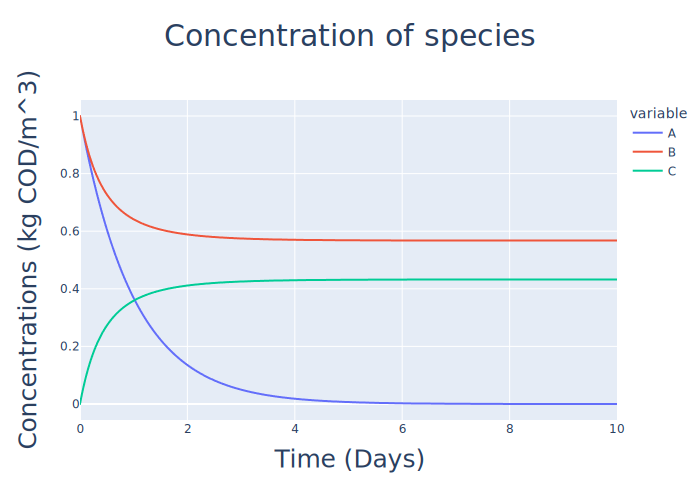

In [3]:
model.plot(model.solve_model(np.linspace(0, 10, 1000))).show(renderer='svg')

## Building a map for the model (optional)
***NOTE: For this step to work, you need to have cobrapy installed.***

First create a cobra model for the model using the script below:

In [4]:
model.build_cobra_model("./toy_model.json")

Name,ADM
Memory address,1036ac1f0
Number of metabolites,3
Number of reactions,2
Number of genes,0
Number of groups,0
Objective expression,0
Compartments,Model


Now you can either use escher map website or the escher python package to create a map for the model. The following script will create a map for the model using the escher python package (you have to have escher installed). Here we assume that the map is built and saved in the same directory as the notebook named "Toymap.json". 

If you want to use a prebuilt map, you can download the map from the escher website and load it using the script below:

In [ ]:
!wget https://raw.githubusercontent.com/chan-csu/ADToolbox/main/Examples/Toymap.json

In [2]:
model.dash_app(sol=model.solve_model(np.linspace(0, 10, 1000)),
                escher_map="./Toymap.json",
                cobra_model="./toy_model.json",
)
                

You built your first model successfully! Now lets use a prebuilt ADM model to analyze. Here we will use e-adm2 which is an extended version of ADM1 that includes more details on VFA metabolism

In [5]:
from adtoolbox import configs,utils,core
import pandas as pd

In [6]:
db=core.Database(configs.Database(adm_parameters_urls=configs.E_ADM_2_REMOTE,adm_parameters=configs.E_ADM_2_LOCAL)) #To make sure the parameters are up to date
db.download_adm_parameters(verbose=False)

As an example, we want to compare gas production between three microbiomes explored in Ding et al. The data for this study is added to the database before (see Parameter Tuning notebook). First lets load the model parameters.The address to the parameter files are in E_ADM_2_LOCAL variable in the configs module and they are in json format. You can either load the files one by one or use a helper function like below:

In [7]:
params=utils.load_multiple_json_files(configs.E_ADM_2_LOCAL)

We can get an examplary food waste as is defined in paramter tuning notebook:

In [8]:
feed=db.get_feed_from_feed_db("name","Foodwaste_for_16s_analysis")[0]

And now let's get a list of experimental setups that we are interested in (Again Ding et al. study), refer to the parameter tuning notebook for more details:

In [9]:
twas=db.get_experiment_from_experiments_db("reference","https://doi.org/10.1021/acssuschemeng.2c04080")[0:2]
twas_as=db.get_experiment_from_experiments_db("reference","https://doi.org/10.1021/acssuschemeng.2c04080")[2:4]
as_=db.get_experiment_from_experiments_db("reference","https://doi.org/10.1021/acssuschemeng.2c04080")[4:]


In [10]:
twas_ic=pd.concat([pd.DataFrame.from_dict(i.initial_concentrations,orient='index') for i in twas],axis=1).mean(axis=1).to_dict()
as_ic=pd.concat([pd.DataFrame.from_dict(i.initial_concentrations,orient='index') for i in as_],axis=1).mean(axis=1).to_dict()
twas_as_ic=pd.concat([pd.DataFrame.from_dict(i.initial_concentrations,orient='index') for i in twas_as],axis=1).mean(axis=1).to_dict()

Now we have everything we need to run the model. Let's create a model object and run the simulation for each experimental setup.

In [11]:
import plotly.graph_objects as go
import plotly.express as px
#make subplots with plotly
import plotly.subplots as tls

In [12]:
gas_data={}
fig=tls.make_subplots(rows=1, cols=2, subplot_titles=("CH4","Acetate"))
for condition in zip([twas_ic,as_ic,twas_as_ic],["TWAS","AS","TWAS_AS"],[1,2,3]):

    model=adm.Model(
        model_parameters=params.model_parameters,
        base_parameters=params.base_parameters,
        initial_conditions=condition[0],
        inlet_conditions=params.inlet_conditions,
        species=params.species,
        reactions=params.reactions,
        build_stoichiometric_matrix=adm.build_e_adm_2_stoichiometric_matrix,
        ode_system=adm.e_adm_2_ode_sys,
        feed=feed,
        control_state={'S_H_ion':10**(-6.5)},
        )
    model.update_parameters(base_parameters={"q_in":0,"V_liq":0.0001,"V_gas":0.00007},model_parameters={"k_p":0})
    sol=model.solve_model(np.linspace(0, 24, 1000))
    gas_data[condition[1]]=sol.y[[model.species.index("S_gas_ch4"),model.species.index("S_ac")],:]
    df=pd.DataFrame(gas_data[condition[1]]).T
    df.columns=["CH4","Acetate"]
    fig.add_trace(go.Scatter(x=sol.t,y=df["CH4"],name=condition[1],line=dict(color=px.colors.qualitative.Plotly[condition[2]])),row=1,col=1)
    fig.add_trace(go.Scatter(x=sol.t,y=df["Acetate"],name=condition[1],line=dict(color=px.colors.qualitative.Plotly[condition[2]]),showlegend=False),row=1,col=2)

    
    fig.update_xaxes(title_text="Time [Days]")
    fig.update_yaxes(title_text="gCOD/l")
    fig.update_layout(title=dict(text="Methane and Acetate Concentration Comparison of TWAS, AS and TWAS_AS",x=0.5))
    
    

    
    

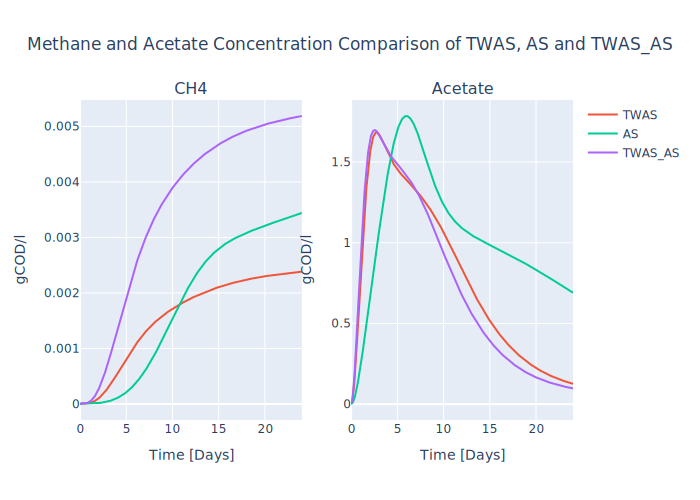

In [13]:
fig.show(renderer='svg')

In [14]:
fig.write_image("methane_acetate.svg")

The pattern here is very similar to the experimental data that is shown in the reference paper. Let's see why metagenomics information is important for predicting methane production.

In [15]:
df_=pd.DataFrame.from_dict([twas_ic,as_ic,twas_as_ic])[["X_Me_ac",'X_Me_CO2']]

In [16]:
df_.set_index(pd.Index(["TWAS","AS","TWAS_AS"]),inplace=True)

In [17]:
df_

,X_Me_ac,X_Me_CO2
TWAS,0.006050,0.000613
AS,0.002170,0.000589
TWAS_AS,0.005998,0.001354


Interestingly, we see that TWAS_AS almost twice as much as methane producers(from CO2) and more producer (from acetate) than AS. AS has the lowest in both group of methanogens. However, it produces more methane than TWAS. The reason for this is that AS has higher acetate later in the experiment.

Finally, just for fun we can launch the web application for our model

In [1]:
model.dash_app(sol=model.solve_model(np.linspace(0, 24, 1000)))
               